# FROMAGe baseline training

## Load LLM

In [2]:
# pip install transformers

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np

DEVICE = torch.device("cuda:0")
DEVICE_CLIP = torch.device("cuda:1")

tokenizer = AutoTokenizer.from_pretrained("TheBloke/Llama-2-7B-fp16", padding_side="left")
model = AutoModelForCausalLM.from_pretrained("TheBloke/Llama-2-7B-fp16").to(DEVICE)

N_EMBEDDINGS = model.model.embed_tokens.weight.shape[0]
EMB_DIM = 4096
EOS_ID = tokenizer.encode("</s>", add_special_tokens=False)[0]
print(EOS_ID, tokenizer.decode([EOS_ID]))
PAD_ID = tokenizer.encode("<unk>", add_special_tokens=False)[0]
print(PAD_ID, tokenizer.decode([PAD_ID]))

## Load CLIP (ImageBind)

In [ ]:
# pip install --upgrade git+https://github.com/facebookresearch/ImageBind.git aac_datasets torchinfo

In [ ]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from aac_datasets import Clotho
from aac_datasets.utils import BasicCollate

root_datasets = "/path/to/your/DATASETS"
dataset_audio_train = Clotho(root=root_datasets, subset="dev", download=False)

In [ ]:
import os.path

from torchinfo import summary

from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

# Instantiate model
model_imagebind = imagebind_model.imagebind_huge(pretrained=True)
model_imagebind.eval()
model_imagebind.to(DEVICE_CLIP)

audio_path = [os.path.join(dataset_audio_train._Clotho__dpath_audio_subset, dataset_audio_train[0]["fname"])]


inputs = {
    ModalityType.AUDIO: data.load_and_transform_audio_data(audio_path, next(model_imagebind.parameters()).device),
}
summary(model_imagebind, input_data=[inputs])

In [ ]:
import torchaudio

from pytorchvideo.data.clip_sampling import ConstantClipsPerVideoSampler

from torchvision import transforms
from torchvision.transforms._transforms_video import NormalizeVideo
from imagebind.data import get_clip_timepoints, waveform2melspec


def load_and_transform_audio_wav_path(
    audio_paths=None,
    waveforms=None,
    srs=None,
    device="cpu",
    num_mel_bins=128,
    target_length=204,
    sample_rate=16000,
    clip_duration=2,
    clips_per_video=3,
    mean=-4.268,
    std=9.138,
):
    if audio_paths is None:
        if waveforms is not None and srs:
            audio_paths = list(zip(waveforms, srs))
        else:
            return None

    audio_outputs = []
    clip_sampler = ConstantClipsPerVideoSampler(clip_duration=clip_duration, clips_per_video=clips_per_video)

    for audio_path in audio_paths:
        if type(audio_path) == str:
            waveform, sr = torchaudio.load(audio_path)
        else:
            waveform, sr = audio_path
        if sample_rate != sr:
            waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=sample_rate)
        all_clips_timepoints = get_clip_timepoints(clip_sampler, waveform.size(1) / sample_rate)
        all_clips = []
        for clip_timepoints in all_clips_timepoints:
            waveform_clip = waveform[
                :,
                int(clip_timepoints[0] * sample_rate) : int(clip_timepoints[1] * sample_rate),
            ]
            waveform_melspec = waveform2melspec(waveform_clip, sample_rate, num_mel_bins, target_length)
            all_clips.append(waveform_melspec)

        normalize = transforms.Normalize(mean=mean, std=std)
        all_clips = [normalize(ac).to(device) for ac in all_clips]

        all_clips = torch.stack(all_clips, dim=0)
        audio_outputs.append(all_clips)

    return torch.stack(audio_outputs, dim=0)

In [ ]:
from imagebind import data
import torch.nn.functional as F


@torch.no_grad()
def encode_audio(audio_paths=None, waveforms=None, srs=None, normalize=True):
    if isinstance(audio_paths, str):
        audio_paths = [audio_paths]
    if isinstance(srs, int):
        srs = [srs]
    if isinstance(waveforms, torch.Tensor):
        waveforms = [waveforms]
    inputs = {
        ModalityType.AUDIO: load_and_transform_audio_wav_path(
            audio_paths=audio_paths, waveforms=waveforms, srs=srs, device=next(model_imagebind.parameters()).device
        ),
    }
    universal_embeddings = model_imagebind(inputs)[ModalityType.AUDIO].to(model.device)
    if normalize:
        universal_embeddings = F.normalize(universal_embeddings, dim=-1)
    return universal_embeddings


@torch.no_grad()
def encode_image(image_paths, normalize=True):
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    inputs = {
        ModalityType.VISION: data.load_and_transform_vision_data(
            image_paths, next(model_imagebind.parameters()).device
        ),
    }
    universal_embeddings = model_imagebind(inputs)[ModalityType.VISION].to(model.device)
    if normalize:
        universal_embeddings = F.normalize(universal_embeddings, dim=-1)
    return universal_embeddings

## Adapter training

In [ ]:
import torch
from torch import nn
from torch.nn import TransformerEncoderLayer

In [ ]:
import glob
from tqdm import tqdm
from PIL import Image
import json


with open(f"{root_datasets}/COCO/annotations/captions_train2017.json") as f:
    coco = json.load(f)
    annotations = coco["annotations"]

idd = annotations[0]["image_id"]
im_id = f"{idd:012d}"
path = f"{root_datasets}/COCO/train2017/{im_id}.jpg"
img = Image.open(path)
encoded_image = encode_image(path)
print(encoded_image.shape, encoded_image.dtype)
img

In [ ]:
import random

MAX_LEN = 30

user_queries_image_en = [
    "What is depicted in this picture?",
    "What is this?",
    "Tell me about this photo",
    "What is it?",
    "Give me a captioning for this image",
    "What can you tell about this?",
    # "Что изображено на этой картинке?",
    # "Что это?",
    # "Что ты видишь на фото?",
    # "Что ты тут видишь? "
    # "Опиши это",
    # "Дай описание этого изображения",
    # "Опиши картинку",
    " ",
]

user_queries_audio_en = [
    "What does this audio sound like?",
    "What is this?",
    "Tell me about this audio",
    "What is it?",
    "Describe this audio",
    "Give me a captioning for this audio",
    "What can you tell about this?",
    # "Что звучит на этом аудио?",
    # "Что это?",
    # "Что ты слышишь на аудио?",
    # "Что ты тут слышишь? "
    # "Опиши это",
    # "Дай описание этого аудио",
    # "Опиши аудио",
    " ",
]


class ImageCaptionsDataset(Dataset):
    def __init__(self, coco):
        super().__init__()
        self.annotations = coco["annotations"]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, i):
        text = self.annotations[i]["caption"]
        im_id = self.annotations[i]["image_id"]
        im_id = f"{im_id:012d}"
        with torch.no_grad():
            path = f"{root_datasets}/COCO/train2017/{im_id}.jpg"
            vision_embs = encode_image(path).to(device=model.device, dtype=model.dtype)
            caption_ids = list(tokenizer.encode(text, add_special_tokens=False))
            caption_ids = caption_ids[:MAX_LEN]
            caption_ids = caption_ids + [PAD_ID] * (MAX_LEN - len(caption_ids))
            caption_ids = torch.LongTensor(caption_ids).to(DEVICE)
            query = random.choice(user_queries_image_en)
            # img = Image.open(path)
            # return vision_embs, caption_ids, query, img
        return vision_embs, caption_ids, query


class AudioCaptionsDataset(Dataset):
    def __init__(self, audio_dataset):
        super().__init__()
        self.audio_dataset = audio_dataset
        self.n_captions = len(audio_dataset[0]["captions"])
        self.length = self.n_captions * len(self.audio_dataset)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        idx = i // self.n_captions
        text = self.audio_dataset[idx]["captions"][i % self.n_captions]
        waveform = self.audio_dataset[idx]["audio"]
        sr = self.audio_dataset[idx]["sr"]
        with torch.no_grad():
            audio_embs = encode_audio(waveforms=waveform, srs=sr).to(device=model.device, dtype=model.dtype)
            caption_ids = list(tokenizer.encode(text, add_special_tokens=False))
            caption_ids = caption_ids[:MAX_LEN]
            caption_ids = caption_ids + [PAD_ID] * (MAX_LEN - len(caption_ids))
            caption_ids = torch.LongTensor(caption_ids).to(DEVICE)
            query = random.choice(user_queries_audio_en)
        return audio_embs, caption_ids, query


dataset_image_captions_train = ImageCaptionsDataset(coco)
dataset_audio_captions_train = AudioCaptionsDataset(dataset_audio_train)

In [ ]:
batch_size = 8
num_workers = 0
dataloader_image_captions_train = DataLoader(
    dataset_image_captions_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
dataloader_audio_captions_train = DataLoader(
    dataset_audio_captions_train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

In [ ]:
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

prompt = "This is a dialog with AI assistant.\n"
ai_ids = tokenizer.encode("\nAssistant: ", add_special_tokens=False, return_tensors="pt").to(DEVICE)
ai_embeddings = model.model.embed_tokens(ai_ids)
print(ai_embeddings.shape)

In [ ]:
# ! pip install datasets==2.13.1 evaluate rouge_score nltk

In [ ]:
from scipy.stats.mstats import gmean
import evaluate, nltk


def bleu_from_prec(precisions, max_order=4):
    return gmean(np.array(precisions[:max_order]))


captioning_metrics = evaluate.combine(
    [
        evaluate.load("bleu"),
        evaluate.load("rouge"),
        evaluate.load("meteor"),
    ]
)

In [ ]:
import glob

val_image_paths = glob.glob(f"{root_datasets}/COCO/val2017/*.jpg")

import json

with open(f"{root_datasets}/COCO/annotations/captions_val2017.json") as f:
    coco_val = json.load(f)

im_id2caps_ru_VAL = {}

for annotation in coco_val["annotations"]:
    key = annotation["image_id"]
    if not key in im_id2caps_ru_VAL:
        im_id2caps_ru_VAL[key] = [annotation["caption"]]
    else:
        im_id2caps_ru_VAL[key] += [annotation["caption"]]

im_id2caps_ru_VAL = {key: im_id2caps_ru_VAL[key] for key in list(im_id2caps_ru_VAL.keys())[::5]}

In [ ]:
class ImagePathCaptionsDataset(Dataset):
    def __init__(self, root, annotations):
        super().__init__()
        self.root = root
        self.annotations = annotations
        self.id_list = list(annotations.keys())

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, i):
        im_id = self.id_list[i]
        caption = self.annotations[im_id]
        im_id = f"{im_id:012d}"
        path = f"{self.root}/{im_id}.jpg"
        return path, caption


dataset_image_captions_val = ImagePathCaptionsDataset(f"{root_datasets}/COCO/val2017", im_id2caps_ru_VAL)
dataset_audio_captions_val = Clotho(root=root_datasets, subset="val", download=False)
len(dataset_image_captions_val), len(dataset_audio_captions_val)

In [ ]:
from aac_datasets.utils import BasicCollate


def collate_path_caption(batch):
    paths, captions = zip(*batch)
    return {"path": list(paths), "captions": list(captions)}


batch_size_val = 25
dataloader_image_captions_val = DataLoader(
    dataset_image_captions_val, batch_size=batch_size_val, collate_fn=collate_path_caption
)
dataloader_audio_captions_val = DataLoader(
    dataset_audio_captions_val, batch_size=batch_size_val, collate_fn=BasicCollate()
)

In [ ]:
class ImageBindToGPTMapping(nn.Module):
    def __init__(self, visual_emb_dim=1024, gpt_emb_dim=5120):
        super(ImageBindToGPTMapping, self).__init__()

        self.image_bind_proj = nn.Linear(visual_emb_dim, gpt_emb_dim)

        bridge_norm_layer = nn.LayerNorm
        bridge_bias = True

        self.image_bind_norm_1 = bridge_norm_layer(gpt_emb_dim)
        self.image_bind_f1_1 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)
        self.image_bind_f2_1 = nn.Linear(gpt_emb_dim * 4, gpt_emb_dim, bias=bridge_bias)
        self.image_bind_f3_1 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)

        self.image_bind_norm_2 = bridge_norm_layer(gpt_emb_dim)
        self.image_bind_f1_2 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)
        self.image_bind_f2_2 = nn.Linear(gpt_emb_dim * 4, gpt_emb_dim, bias=bridge_bias)
        self.image_bind_f3_2 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)

        self.image_bind_norm_3 = bridge_norm_layer(gpt_emb_dim)
        self.image_bind_f1_3 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)
        self.image_bind_f2_3 = nn.Linear(gpt_emb_dim * 4, gpt_emb_dim, bias=bridge_bias)
        self.image_bind_f3_3 = nn.Linear(gpt_emb_dim, gpt_emb_dim * 4, bias=bridge_bias)

    def forward(self, embeddings):
        embeddings = F.normalize(embeddings, dim=-1)
        modality_feats = embeddings.unsqueeze(1)  # B, 1, D
        modality_feats = self.image_bind_proj(modality_feats)
        modality_feats_norm = self.image_bind_norm_1(modality_feats)
        modality_feats = modality_feats + self.image_bind_f2_1(
            F.silu(self.image_bind_f1_1(modality_feats_norm)) * self.image_bind_f3_1(modality_feats_norm)
        )

        modality_feats_norm = self.image_bind_norm_2(modality_feats)
        modality_feats = modality_feats + self.image_bind_f2_2(
            F.silu(self.image_bind_f1_2(modality_feats_norm)) * self.image_bind_f3_2(modality_feats_norm)
        )

        modality_feats_norm = self.image_bind_norm_3(modality_feats)
        modality_feats = modality_feats + self.image_bind_f2_3(
            F.silu(self.image_bind_f1_3(modality_feats_norm)) * self.image_bind_f3_3(modality_feats_norm)
        )
        return modality_feats.squeeze(1)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

N_EPOCHS = 10
N_ITERS = 5000
N_MODALITY_EMBS = 4
ENC_DIM = model_imagebind.modality_heads[ModalityType.VISION][-1].out_features

EXP_NAME = "LLaMa-7b-EN-Linear-ImageBind"

if "Linear" in EXP_NAME:
    projection = nn.Linear(ENC_DIM, N_MODALITY_EMBS * EMB_DIM).to(device=model.device, dtype=model.dtype)
else:
    projection = ImageBindToGPTMapping(ENC_DIM, N_MODALITY_EMBS * EMB_DIM).to(device=model.device, dtype=model.dtype)

img_tokens_emb = [
    nn.Parameter(
        torch.normal(torch.zeros(EMB_DIM), torch.ones(EMB_DIM) / EMB_DIM**0.5).to(
            device=model.device, dtype=model.dtype
        ),
        requires_grad=True,
    )
    for _ in range(2)
]

audio_tokens_emb = [
    nn.Parameter(
        torch.normal(torch.zeros(EMB_DIM), torch.ones(EMB_DIM) / EMB_DIM**0.5).to(
            device=model.device, dtype=model.dtype
        ),
        requires_grad=True,
    )
    for _ in range(2)
]

grad_accum_steps = 16
effective_batch_size = grad_accum_steps * batch_size
base_lr = 3e-3
lr = base_lr * effective_batch_size / 256

# opt = Adafactor(list(projection.parameters()) + [img_start_emb] + [img_end_emb], lr = lr, relative_step=False)
num_warmup_steps = 50
opt = torch.optim.AdamW(list(projection.parameters()) + img_tokens_emb + audio_tokens_emb, lr=lr, betas=(0.9, 0.95))
lr_scheduler = get_cosine_schedule_with_warmup(opt, num_warmup_steps=num_warmup_steps, num_training_steps=N_ITERS)
loss_fct = nn.CrossEntropyLoss(reduction="none", ignore_index=PAD_ID)

In [ ]:
bad_words_ids = tokenizer(
    [":", "Пользователь", "Ассистент", "Bot", "<|SOI|>", "<|EOI|>", "<|SOA|>", "<|EOA|>"]
).input_ids

gen_params = {
    "do_sample": False,
    # "temperature": 1.,
    # "typical_p": 0.1,
    # "top_p": 0.17,
    "max_new_tokens": 100,
    "early_stopping": True,
    "num_beams": 3,
    "repetition_penalty": 2.5,
    "remove_invalid_values": True,
    "eos_token_id": 29889,
    "pad_token_id": 29889,
    "forced_eos_token_id": 29889,
    "use_cache": True,
    "no_repeat_ngram_size": 4,
    # "length_penalty": 0.1,
    "bad_words_ids": bad_words_ids,
    "num_return_sequences": 3,
}

BOT_NAME = "Assistant:"
USER_NAME = "User:"


@torch.no_grad()
def gen_answer(query, image=None, audio=None):
    if image or audio:
        if image:
            modality_embedding = encode_image(image).to(device=model.device, dtype=model.dtype)
            modality_start_emb, modality_end_emb = img_tokens_emb
        elif audio:
            modality_embedding = encode_audio(audio).to(device=model.device, dtype=model.dtype)
            modality_start_emb, modality_end_emb = audio_tokens_emb
        bs = modality_embedding.shape[0]
        projected_modality_embs = projection(modality_embedding)
        prompt_and_query = f"{prompt}\nUser: {query} "
        prompt_ids = tokenizer.encode(prompt_and_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
        prompt_embeddings = model.model.embed_tokens(prompt_ids)

        embeddings = torch.cat(
            [
                prompt_embeddings.repeat(bs, 1, 1),
                modality_start_emb[None, None].repeat(bs, 1, 1),
                projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
                modality_end_emb[None, None].repeat(bs, 1, 1),
                ai_embeddings.repeat(bs, 1, 1),
            ],
            dim=1,
        )

    # print(wrapped)
    out = model.generate(
        inputs_embeds=embeddings,
        **gen_params,
    )
    out = out[:, 1:]
    generated_texts = tokenizer.batch_decode(out)
    return generated_texts


test_images = {
    f"{root_datasets}/test_photos/elbrus.png": "What is its name?",
    f"{root_datasets}/test_photos/painting.png": "Who is the author?",
    f"{root_datasets}/test_photos/putin.jpeg": "Who is it?",
    f"{root_datasets}/test_photos/china.jpeg": "Who is it?",
    f"{root_datasets}/test_photos/fruits.jpeg": "What is it?",
}


def test():
    predicted_text = ""
    for path in test_images.keys():
        query = test_images[path]
        answer = gen_answer(query, image=path)
        print(answer)
        predicted_text += f"\n{answer}"
        with open(f"testText_{EXP_NAME}.txt", "w") as f:
            f.write(predicted_text)


test_audios = {
    f"{root_datasets}/test_audios/043015 Splashing water in bathtub.wav": "What is happening in the audio?",
    f"{root_datasets}/test_audios/080902_05_cicada_night_road.wav": "What is happening in the image?",
    f"{root_datasets}/test_audios/01862 heavy machine working.wav": "Describe it",
    f"{root_datasets}/test_audios/dog_audio.wav": "What is happening here?",
    f"{root_datasets}/test_audios/car_audio.wav": "What is happening in the image?",
    f"{root_datasets}/test_audios/bird_audio.wav": "Describe it",
}


def test_audio():
    predicted_text = ""
    for path in test_audios.keys():
        query = test_audios[path]
        answer = gen_answer(query, audio=path)
        print(answer)
        predicted_text += f"\n{answer}"
        with open(f"testText_{EXP_NAME}_audio.txt", "w") as f:
            f.write(predicted_text)

In [ ]:
test()

In [ ]:
test_audio()

In [ ]:
def process_batch_train(batch, modality_tokens_emb):
    modality_embedding, caption_ids, user_query = batch
    modality_start_emb, modality_end_emb = modality_tokens_emb

    user_query_ids = tokenizer.encode(user_query[0], add_special_tokens=False, return_tensors="pt").to(DEVICE)
    user_query_embeddings = model.model.embed_tokens(user_query_ids)

    bs = modality_embedding.shape[0]
    projected_modality_embs = projection(modality_embedding)
    text_embeddings = model.model.embed_tokens(caption_ids)
    prompt_and_query = f"{prompt}\nUser: {user_query} "
    prompt_ids = tokenizer.encode(prompt_and_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
    prompt_embeddings = model.model.embed_tokens(prompt_ids)

    embeddings1 = torch.cat(
        [
            prompt_embeddings.repeat(bs, 1, 1),
            modality_start_emb[None, None].repeat(bs, 1, 1),
            projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
            modality_end_emb[None, None].repeat(bs, 1, 1),
            ai_embeddings.repeat(bs, 1, 1),
        ],
        dim=1,
    )

    embeddings2 = text_embeddings

    embeddings = torch.cat([embeddings1, embeddings2], dim=1)

    outputs = model(inputs_embeds=embeddings, output_hidden_states=True)
    logits = outputs.get("logits")
    logits = logits[..., embeddings1.shape[1] - 1 : -1, :].contiguous()
    labels = caption_ids.contiguous()
    loss_ce = loss_fct(logits.view(-1, N_EMBEDDINGS), labels.flatten()).mean()

    loss = loss_ce

    loss.backward(retain_graph=True)
    return loss.item()

In [ ]:
from tqdm import tqdm
import glob
import pandas as pd

sample_predictions = ["привет Антон", "hello there general kenobi"]
sample_references = [["Привет! Как тебя зовут?", "Привет Антон!"], [["hello there general kenobi"], ["hello there!"]]]

metrics_val = captioning_metrics.compute(predictions=sample_predictions, references=sample_references)
for i in range(1, 5):
    metrics_val[f"bleu{i}"] = bleu_from_prec(metrics_val["precisions"], i)
metrics_val["task"] = ""
metrics_val["step"] = ""
metrics_val["loss_ce"] = ""
metrics_val.pop("precisions")

metrics_dict = {k: [] for k in metrics_val.keys()}

iters = 0

losses = []
losses_batch = []
best_metric = 0.

for epoch in range(N_EPOCHS):
    dataloader_audio_captions_train_iter = iter(dataloader_audio_captions_train)
    for batch_image in dataloader_image_captions_train:
        losses_batch.append(process_batch_train(batch_image, img_tokens_emb))
        
        try:
            batch_audio = next(dataloader_audio_captions_train_iter)
        except StopIteration:
            dataloader_audio_captions_train_iter = iter(dataloader_audio_captions_train)
            batch_audio = next(dataloader_audio_captions_train_iter)
        
        losses_batch.append(process_batch_train(batch_audio, audio_tokens_emb))
        
        if iters % grad_accum_steps == 0:
            step = iters // grad_accum_steps
            clear_output(True)
            opt.step()
            opt.zero_grad()
            lr_scheduler.step()
            if iters % (grad_accum_steps * 4) == 0:
                with torch.no_grad():
                    user_query = "Describe what is happening here."
                    user_query_ids = tokenizer.encode(user_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
                    user_query_embeddings = model.model.embed_tokens(user_query_ids)
                    prompt = "This is a dialog with AI assistant.\n"
                    ai_ids = tokenizer.encode("\nAssistant: ", add_special_tokens=False, return_tensors="pt").to(DEVICE)
                    ai_embeddings = model.model.embed_tokens(ai_ids)
                    prompt_and_query = f"{prompt}\nUser: {user_query} "
                    prompt_ids = tokenizer.encode(prompt_and_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
                    prompt_embeddings = model.model.embed_tokens(prompt_ids)
                    
                    gold_caps = []
                    predictions = []
                    for batch_image in tqdm(dataloader_image_captions_val):
                        gold_cap = batch_image["captions"]
                        modality_embedding = encode_image(batch_image["path"]).to(device=model.device, dtype=model.dtype)
                        modality_start_emb, modality_end_emb = img_tokens_emb

                        bs = modality_embedding.shape[0]
                        projected_modality_embs = projection(modality_embedding)
                        
                        embeddings = torch.cat(
                            [
                                prompt_embeddings.repeat(bs, 1, 1),
                                user_query_embeddings.repeat(bs, 1, 1),
                                modality_start_emb[None, None].repeat(bs, 1, 1),
                                projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
                                modality_end_emb[None, None].repeat(bs, 1, 1),
                                ai_embeddings.repeat(bs, 1, 1),
                            ],
                            dim=1,
                        )

                        outputs = model.generate(
                            inputs_embeds=embeddings,
                            early_stopping=True,
                            eos_token_id=29889,
                            pad_token_id=29889,
                            forced_eos_token_id=29889,
                        )
                        pred_caption = tokenizer.batch_decode(outputs[:, 1:-1])

                        gold_caps += gold_cap
                        predictions += pred_caption
                    
                    metrics_val = captioning_metrics.compute(predictions=predictions, references=gold_caps)
                    for i in range(1, 5):
                        metrics_val[f"bleu{i}"] = bleu_from_prec(metrics_val["precisions"], i)
                    metrics_val["task"] = "img"
                    metrics_val["step"] = step
                    metrics_val.pop("precisions")
                    metrics_val["loss_ce"] = np.mean(losses_batch)
                    for k in metrics_dict.keys():
                        metrics_dict[k].append(metrics_val[k])
                    
                    gold_caps = []
                    predictions = []
                    for batch_audio in tqdm(dataloader_audio_captions_val):
                        gold_cap = batch_audio["captions"]
                        modality_embedding = encode_audio(waveforms=batch_audio["audio"], srs=batch_audio["sr"]).to(
                            device=model.device, dtype=model.dtype
                        )
                        modality_start_emb, modality_end_emb = audio_tokens_emb
                        bs = modality_embedding.shape[0]
                        projected_modality_embs = projection(modality_embedding)
                        
                        embeddings = torch.cat(
                            [
                                prompt_embeddings.repeat(bs, 1, 1),
                                user_query_embeddings.repeat(bs, 1, 1),
                                modality_start_emb[None, None].repeat(bs, 1, 1),
                                projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
                                modality_end_emb[None, None].repeat(bs, 1, 1),
                                ai_embeddings.repeat(bs, 1, 1),
                            ],
                            dim=1,
                        )

                        outputs = model.generate(
                            inputs_embeds=embeddings,
                            early_stopping=True,
                            eos_token_id=29889,
                            pad_token_id=29889,
                            forced_eos_token_id=29889,
                        )
                        pred_caption = tokenizer.batch_decode(outputs[:, 1:-1])

                        gold_caps += gold_cap
                        predictions += pred_caption
                    
                    metrics_val = captioning_metrics.compute(predictions=predictions, references=gold_caps)
                    for i in range(1, 5):
                        metrics_val[f"bleu{i}"] = bleu_from_prec(metrics_val["precisions"], i)
                    metrics_val["task"] = "audio"
                    metrics_val["step"] = step
                    metrics_val.pop("precisions")
                    metrics_val["loss_ce"] = np.mean(losses_batch)
                    for k in metrics_dict.keys():
                        metrics_dict[k].append(metrics_val[k])
                    
                    metrics_df = pd.DataFrame(metrics_dict)
                    val_agg_metric = metrics_df.loc[metrics_df["step"] == step, ["bleu", "rouge1", "rouge2", "rougeL", "rougeLsum", "meteor"]].mean().sum()
                    if val_agg_metric > best_metric:
                        torch.save(projection, f'projection_{EXP_NAME}')
                        torch.save(img_tokens_emb, f'IMG_EMB_{EXP_NAME}')
                        torch.save(audio_tokens_emb, f'AUDIO_EMB_{EXP_NAME}')
                        best_metric = val_agg_metric

                    metrics_df.to_csv(f"{EXP_NAME}_metrics.csv", index=False)

            losses.append(np.mean(losses_batch))
            losses_batch = []
            
            print(f"Step: {step}")
            
            plt.title("train loss")
            plt.semilogy(losses)
            plt.grid()
            plt.savefig(f'loss_{EXP_NAME}.pdf', bbox_inches="tight")
            plt.show()

            print("SAVED!")
            print("Image captioning:")
            test()
            print("Audio captioning:")
            test_audio()

        iters += 2

In [ ]:
test()

In [ ]:
test_audio()

In [ ]:
for gold, pred in zip(gold_cap, pred_caption):
    print("Gold:\n" + "\n".join(gold) + "\n" + "Pred:\n" + pred + "\n")

## Evaluation

In [ ]:
import pandas as pd
import seaborn as sns

In [14]:
EXP_NAME = "LLaMa-7b-EN-Linear-ImageBind"

metrics_df = pd.read_csv(f"{EXP_NAME}_metrics.csv")

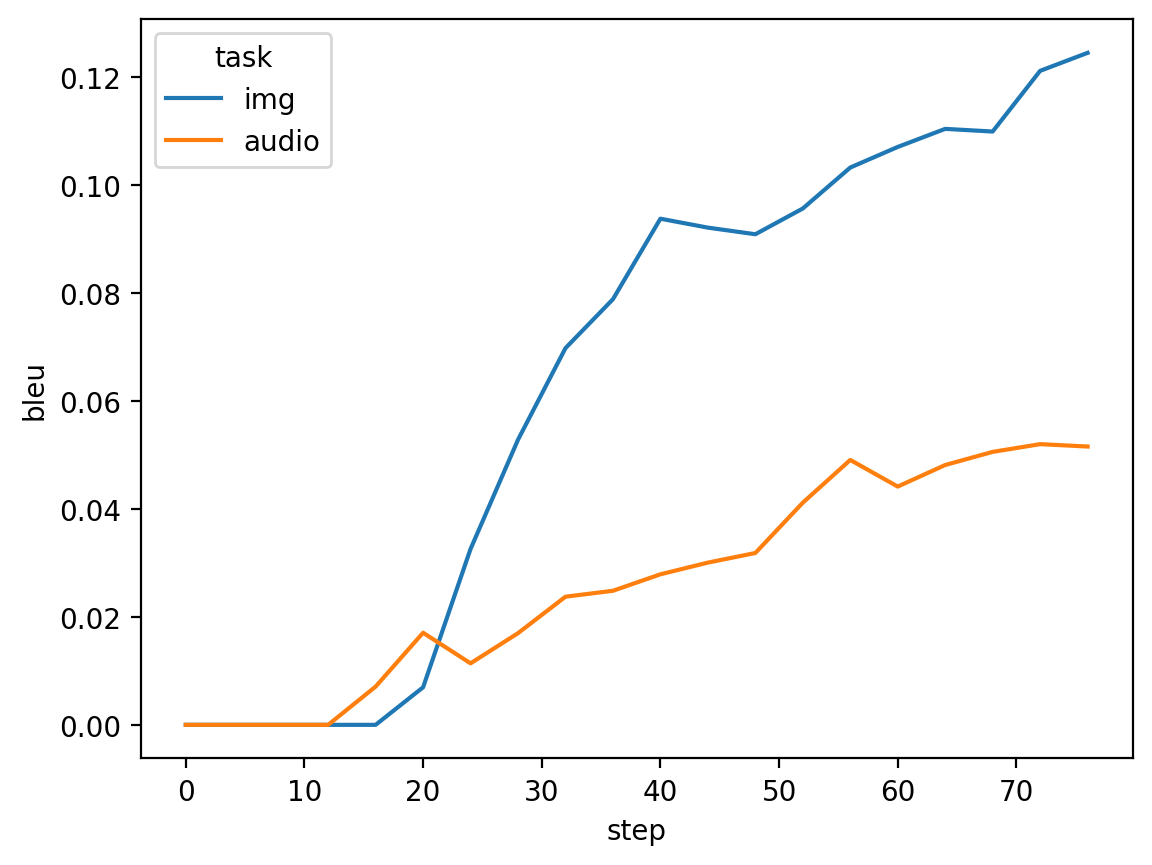

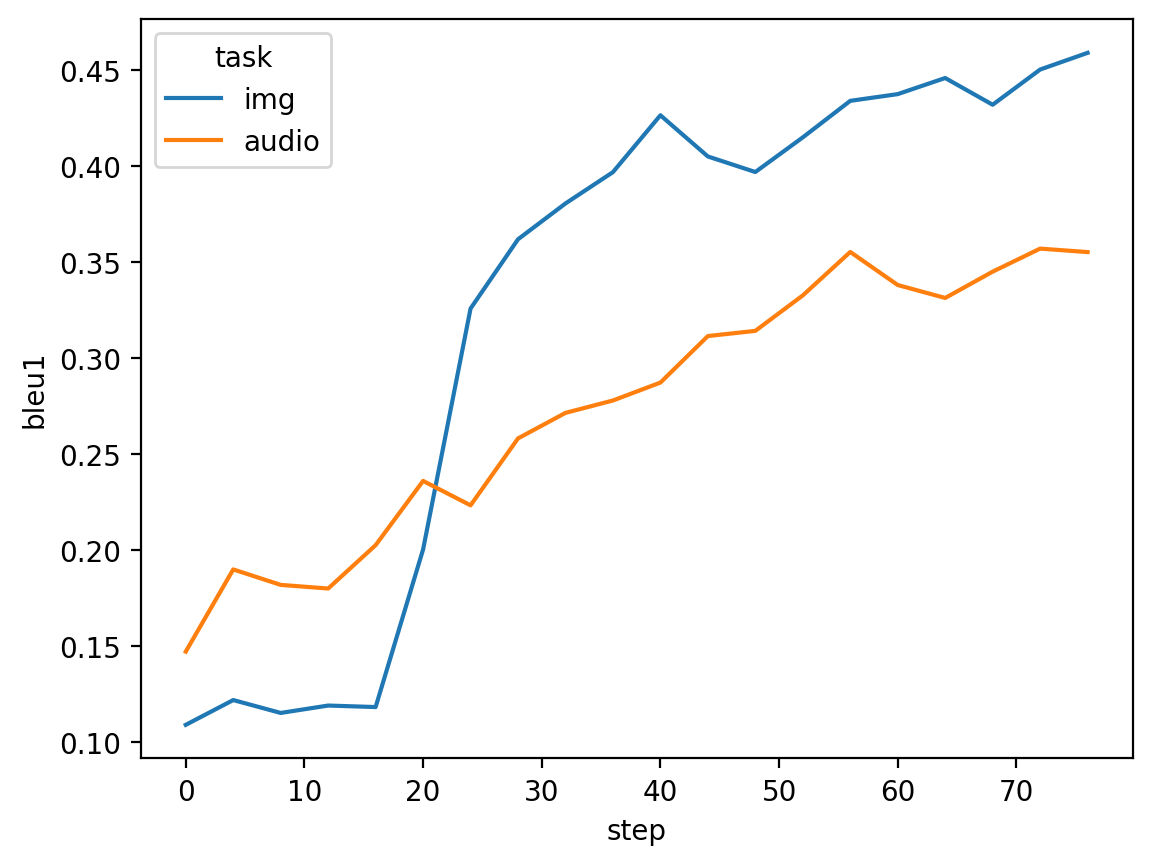

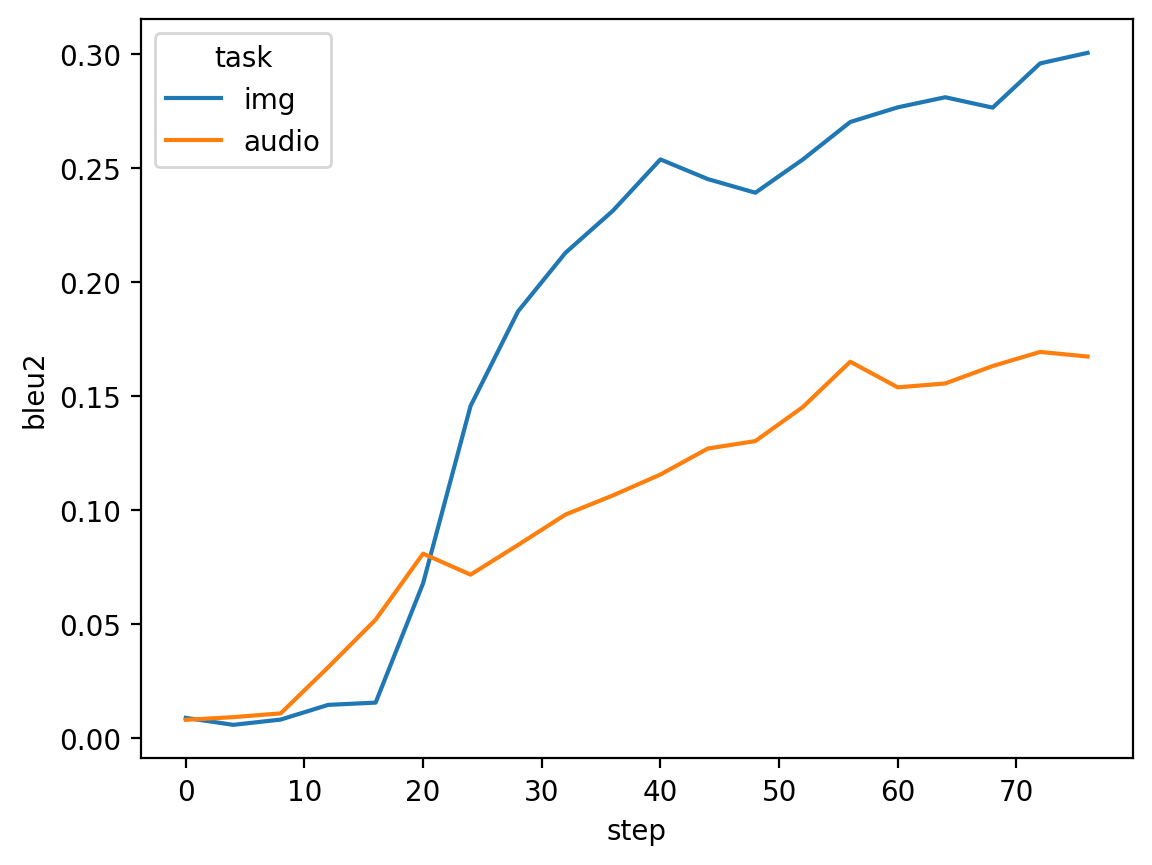

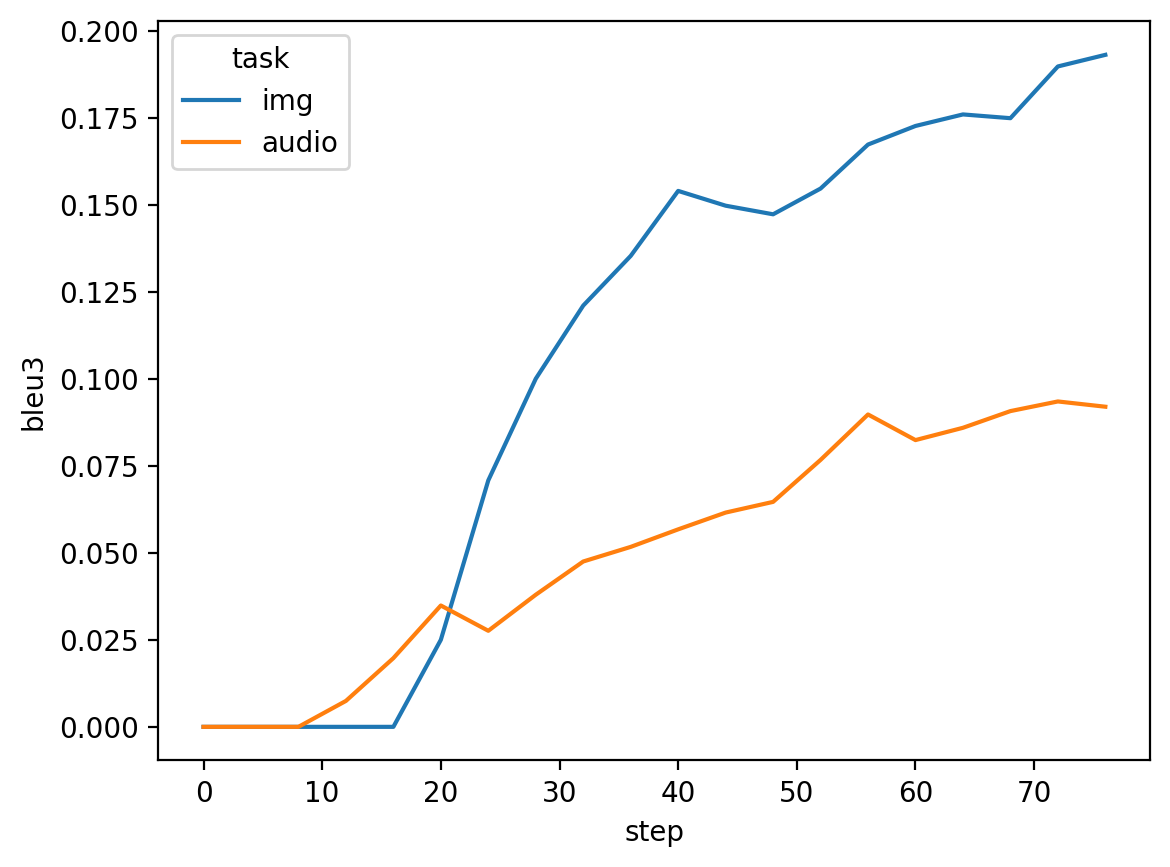

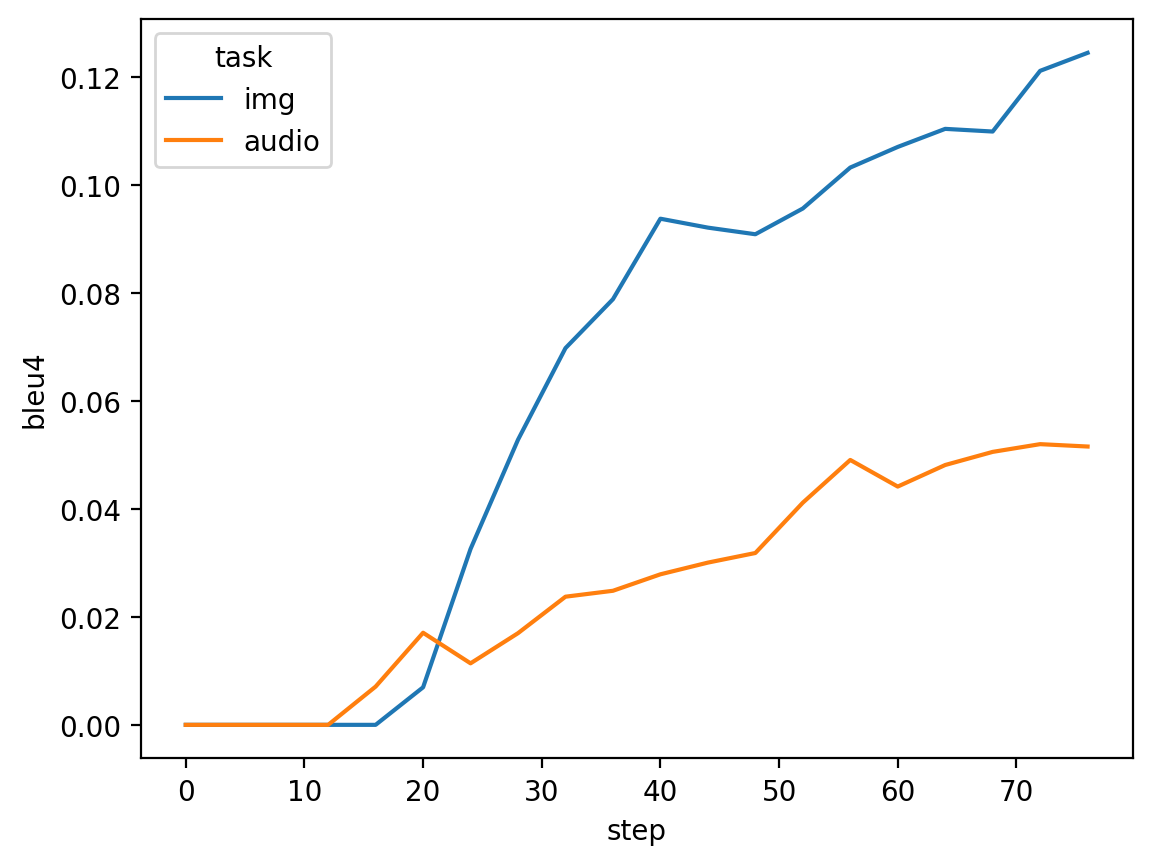

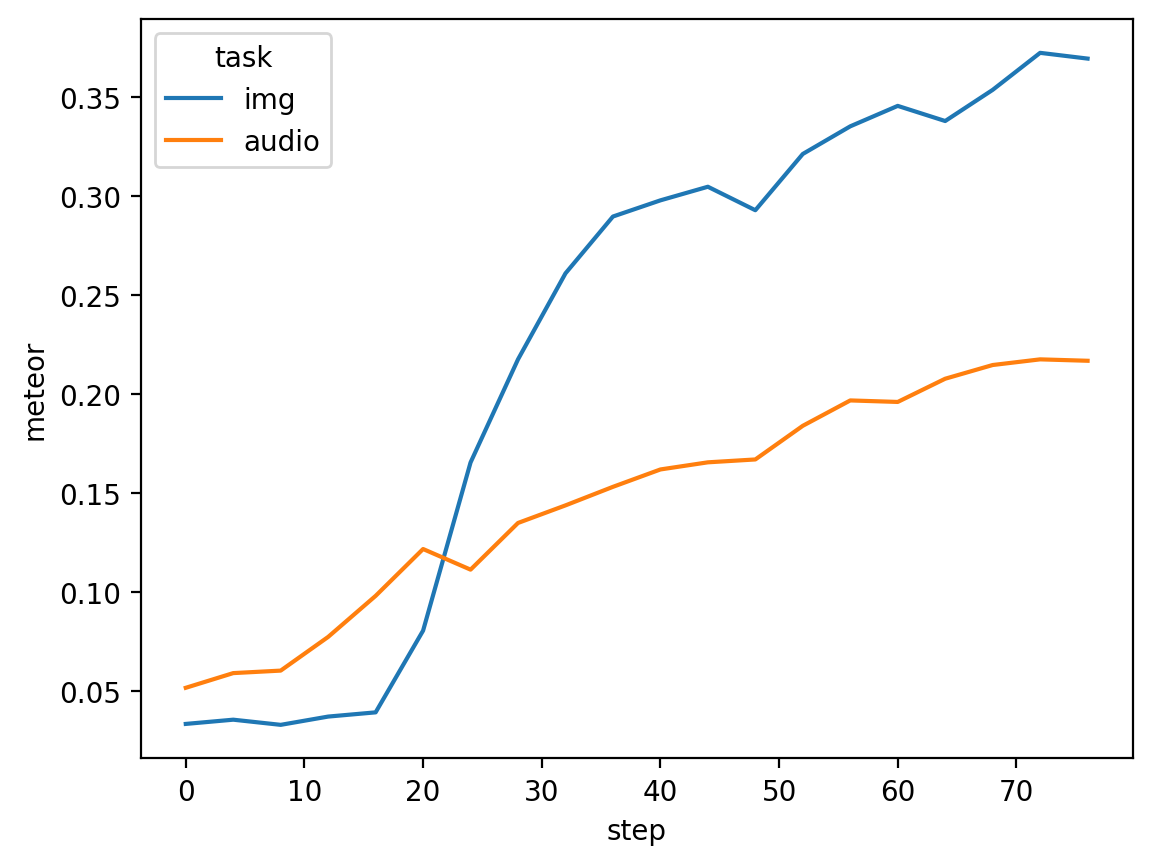

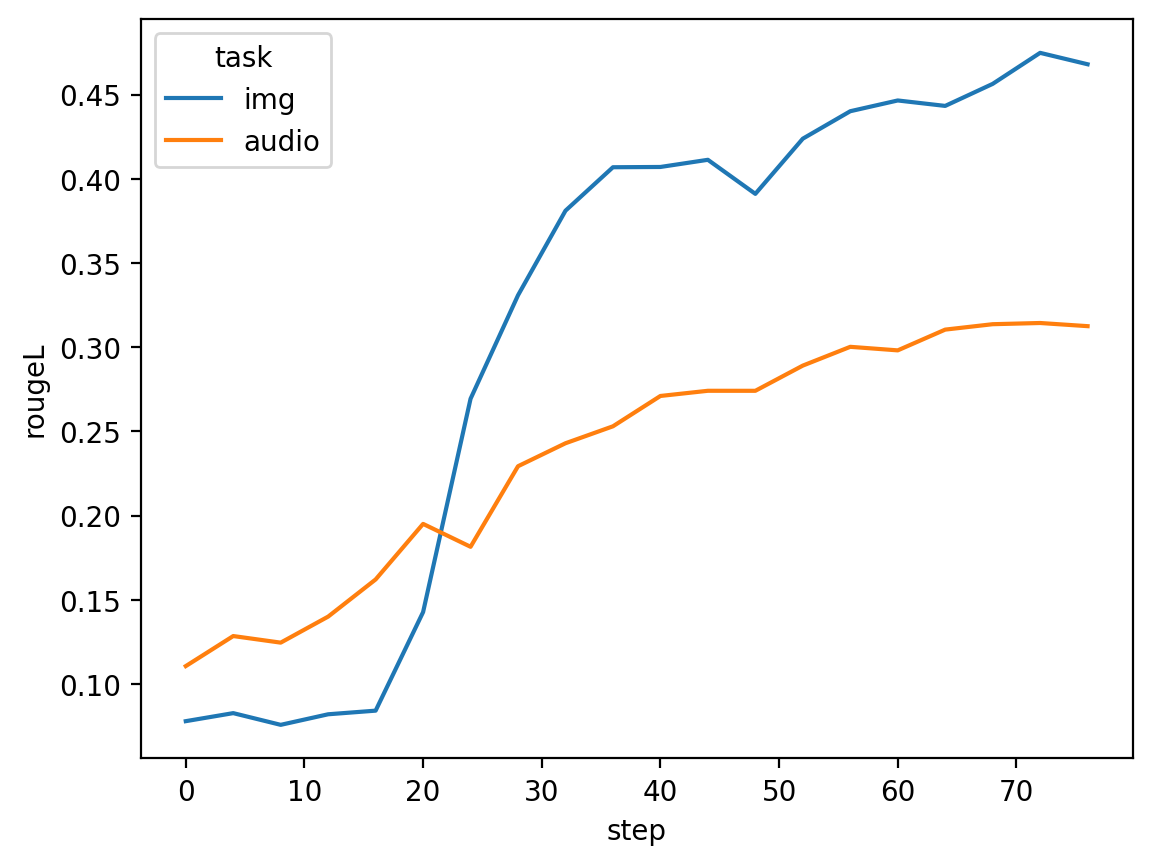

In [15]:
for y in ["bleu", "bleu1", "bleu2", "bleu3", "bleu4", "meteor", "rougeL"]:
    sns.lineplot(metrics_df, hue="task", x="step", y=y)
    plt.show()

In [ ]:
with torch.no_grad():
    user_query = "Describe what is happening here."
    user_query_ids = tokenizer.encode(user_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
    user_query_embeddings = model.model.embed_tokens(user_query_ids)
    prompt = "This is a dialog with AI assistant.\n"
    ai_ids = tokenizer.encode("\nAssistant: ", add_special_tokens=False, return_tensors="pt").to(DEVICE)
    ai_embeddings = model.model.embed_tokens(ai_ids)
    prompt_and_query = f"{prompt}\nUser: {user_query} "
    prompt_ids = tokenizer.encode(prompt_and_query, add_special_tokens=False, return_tensors="pt").to(DEVICE)
    prompt_embeddings = model.model.embed_tokens(prompt_ids)

    gold_caps = []
    predictions = []
    for batch_image in tqdm(dataloader_image_captions_val):
        gold_cap = batch_image["captions"]
        modality_embedding = encode_image(batch_image["path"]).to(device=model.device, dtype=model.dtype)
        modality_start_emb, modality_end_emb = img_tokens_emb

        bs = modality_embedding.shape[0]
        projected_modality_embs = projection(modality_embedding)

        embeddings = torch.cat(
            [
                prompt_embeddings.repeat(bs, 1, 1),
                user_query_embeddings.repeat(bs, 1, 1),
                modality_start_emb[None, None].repeat(bs, 1, 1),
                projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
                modality_end_emb[None, None].repeat(bs, 1, 1),
                ai_embeddings.repeat(bs, 1, 1),
            ],
            dim=1,
        )

        outputs = model.generate(
            inputs_embeds=embeddings,
            early_stopping=True,
            eos_token_id=29889,
            pad_token_id=29889,
            forced_eos_token_id=29889,
        )
        pred_caption = tokenizer.batch_decode(outputs[:, 1:-1])

        gold_caps += gold_cap
        predictions += pred_caption

    metrics_val = captioning_metrics.compute(predictions=predictions, references=gold_caps)
    for i in range(1, 5):
        metrics_val[f"bleu{i}"] = bleu_from_prec(metrics_val["precisions"], i)
    metrics_val["task"] = "img"
    metrics_val["step"] = step
    metrics_val.pop("precisions")
    for k in metrics_dict.keys():
        metrics_dict[k].append(metrics_val[k])

    gold_caps = []
    predictions = []
    for batch_audio in tqdm(dataloader_audio_captions_val):
        gold_cap = batch_audio["captions"]
        modality_embedding = encode_audio(waveforms=batch_audio["audio"], srs=batch_audio["sr"]).to(
            device=model.device, dtype=model.dtype
        )
        modality_start_emb, modality_end_emb = audio_tokens_emb
        bs = modality_embedding.shape[0]
        projected_modality_embs = projection(modality_embedding)

        embeddings = torch.cat(
            [
                prompt_embeddings.repeat(bs, 1, 1),
                user_query_embeddings.repeat(bs, 1, 1),
                modality_start_emb[None, None].repeat(bs, 1, 1),
                projected_modality_embs.reshape(bs, N_MODALITY_EMBS, EMB_DIM),
                modality_end_emb[None, None].repeat(bs, 1, 1),
                ai_embeddings.repeat(bs, 1, 1),
            ],
            dim=1,
        )

        outputs = model.generate(
            inputs_embeds=embeddings,
            early_stopping=True,
            eos_token_id=29889,
            pad_token_id=29889,
            forced_eos_token_id=29889,
        )
        pred_caption = tokenizer.batch_decode(outputs[:, 1:-1])

        gold_caps += gold_cap
        predictions += pred_caption

    metrics_val = captioning_metrics.compute(predictions=predictions, references=gold_caps)
    for i in range(1, 5):
        metrics_val[f"bleu{i}"] = bleu_from_prec(metrics_val["precisions"], i)
    metrics_val["task"] = "audio"
    metrics_val["step"] = step
    metrics_val.pop("precisions")
    for k in metrics_dict.keys():
        metrics_dict[k].append(metrics_val[k])

    metrics_df = pd.DataFrame(metrics_dict)
metrics_df

In [ ]:
# import nltk


# def evaluate_bleu_score(gold_caps, predictions, ngram=4):
#     bleu_scores = []

#     for reference_captions, pred_caption in zip(gold_caps, predictions):
#         # Tokenize the reference and predicted captions
#         tokenized_references = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
#         tokenized_pred = nltk.word_tokenize(pred_caption.lower())

#         # Compute the BLEU score for the prediction
#         bleu_score = nltk.translate.bleu_score.sentence_bleu(
#             tokenized_references, tokenized_pred, weights=[1 / ngram] * ngram
#         )
#         bleu_scores.append(bleu_score)

#     # Calculate the average BLEU score
#     avg_bleu = sum(bleu_scores) / len(bleu_scores)
#     return avg_bleu

In [ ]:
# gold_caps = [["Привет! Как тебя зовут?", "Привет Антон!"]]
# predictions = ["привет Антон"]
# evaluate_bleu_score(gold_caps, predictions, ngram=4)

# # Calculate the BLEU score for your predictions
# bleu_1 = evaluate_bleu_score(gold_caps, predictions, ngram=1)
# bleu_2 = evaluate_bleu_score(gold_caps, predictions, ngram=2)
# bleu_3 = evaluate_bleu_score(gold_caps, predictions, ngram=3)
# bleu_4 = evaluate_bleu_score(gold_caps, predictions, ngram=4)

# print("BLEU-1: {:.2f}".format(bleu_1))
# print("BLEU-2: {:.2f}".format(bleu_2))
# print("BLEU-3: {:.2f}".format(bleu_3))
# print("BLEU-4: {:.2f}".format(bleu_4))

In [ ]:
for gold, pred in zip(gold_cap, pred_caption):
    print("Gold:\n" + "\n".join(gold) + "\n" + "Pred:\n" + pred + "\n")